# All-dielectric metasurface absorber

Metamaterials and metasurfaces can achieve functionalities that are not available to naturally occurring materials such as negative refractive index. Originally, metamaterials often utilize metallic structures. These metallic structures, such as split ring resonators, exhibit strong resonances at specific frequencies, which can be effectively tuned by adjusting the geometric parameters. However, metals exhibit large loss at optical frequencies. This can greatly impair the performance of the metamaterials. As a consequence, metamaterials fully based on dielectric materials have attracted a lot of interest recently.

Electromagnetic absorber is one of the most popular categories of metasurfaces. Metasurfaces with high absorption can be used as radiation power detectors since they convert electromagnetic radiation into thermal energy at high efficiency. This model demonstrates how to simulate an all-dielectric metasurface absorber at the THz regime. The design consists of a cylindrical silicon resonator on a thin PDMS substrate. The design parameters are adapted from [Kebin Fan, Jonathan Y. Suen, Xinyu Liu, and Willie J. Padilla, "All-dielectric metasurface absorbers for uncooled terahertz imaging," Optica 4, 601-604 (2017)](https://opg.optica.org/optica/fulltext.cfm?uri=optica-4-6-601&id=367183).

<img src="img/metasurface.png">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web


## Simulation Setup 

The absorption peak of the metasurface is designed to be around 0.6 THz. Therefore, we aim to simulate a frequency range from 0.4 THz to 0.8 THz. 

In [2]:
THz = 1e12  # convertion factor from Hz to THz
freqs = np.linspace(0.4 * THz, 0.8 * THz, 100)  # freqeucny range of the simulation
freq0 = 0.6 * THz  # central frequency
freqw = 0.4 * THz  # width of the frequency range
lda0 = td.C_0 / freq0  # central wavelength


Two materials are involved in this model. The dielectric cylinder is made of silicon, which is described by a Drude model with $\varepsilon_{\inf}$=11.7 and plasma frequency $\omega_P$=0.69 THz and damping rate $\gamma$=0.83 THz. We can use the built-in [Drude](../_autosummary/tidy3d.Drude.html?highlight=drude) feature to describe the response of silicon. The thin substrate is made of PDMS, which has a relative permittivity of 1.72 and a loss tangent of 0.15 at the relevant frequency range. The relative permittivity and loss tangent will be converted to the complex refractive index then PDMS can be described by using the `from_nk` method of [Medium](../_autosummary/tidy3d.Medium.html).

In [3]:
w_p = 0.69 * THz  # plasma frequency of Si
gamma = 0.83 * THz  # damping rate of Si
Si = td.Drude(
    eps_inf=11.7, coeffs=[(w_p, gamma)]
)  # using drude model to describe the response of silicon

loss_tan = 0.15  # loss tangent of PDMS
eps_pdms = 1.72 + 1j * 1.72 * loss_tan  # complex permittivity of PDMS
n_pdms = np.sqrt(eps_pdms)  # refractive index of PDMS
PDMS = td.Medium.from_nk(
    n=np.real(n_pdms), k=np.imag(n_pdms), freq=freq0
)  # define PDMS with the complex refractive index


The unit cell of the metasurface consists of a cylindrical silicon resonator on a thin PDMS substrate. The periodicity is 330 $\mu m$. The cylinder radius and height are 106 $\mu m$ and 85 $\mu m$, respectively. The substrate is only 8 $\mu m$ thick.

In [4]:
p = 330  # unit cell size
h = 85  # height of the cylinder
r = 106  # radius of the cylinder
t = 8  # thickness of the substrate


Define the simulation domain and the unit cell structure.

In [5]:
# simulation domain size
# simulation size is the periodicity of the unit cell in x and y directions
# in z direction, the size is set to 2 central wavelength
Lx, Ly, Lz = p, p, 2 * lda0
sim_size = [Lx, Ly, Lz]

# construct the pdms substrate
substrate = td.Structure(
    geometry=td.Box(center=[0, 0, -t / 2], size=[td.inf, td.inf, t]), medium=PDMS
)

# construct the silicon resonator
cylinder = td.Structure(
    geometry=td.Cylinder(center=[0, 0, h / 2], radius=r, length=h, axis=2), medium=Si
)


The metasurface is excited by a plane wave at normal incidence. To measure the transmission, reflection, and absorption, we set up two flux monitors, one on the incident side and one on the transmission side. An additional field monitor is added so that we can visualize the resonance mode profile at the absorption peak.

In [6]:
# add a plane wave source
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=0.5 * freqw),
    size=(td.inf, td.inf, 0),
    center=(0, 0, 0.3 * lda0),
    direction="-",
    pol_angle=0,
)

# add a flux monitor to detect transmission
monitor_t = td.FluxMonitor(
    center=[0, 0, -0.4 * Lz], size=[td.inf, td.inf, 0], freqs=freqs, name="T"
)

# add a flux monitor to detect reflection
monitor_r = td.FluxMonitor(
    center=[0, 0, 0.4 * Lz], size=[td.inf, td.inf, 0], freqs=freqs, name="R"
)

# add a field monitor to see the field profile at the absorption peak frequency
monitor_field = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, lda0], freqs=[freq0], name="field"
)


Set up the Simulation object. The minimal mesh size per wavelength is set to 40 to ensure it resolves the structure well.

In [7]:
run_time = 3e-10  # simulation run time

# set up simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=40, wavelength=lda0),
    structures=[substrate, cylinder],
    sources=[plane_wave],
    monitors=[monitor_t, monitor_r, monitor_field],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    ),
    symmetry=(-1, 1, 0),
)  # symmetry can be used to greatly reduce the computational cost


Before submitting the simulation job to the server, it is always a good practice to verify if the settings are correct. For example, we can check if the frequency spectrum of the source covers the frequency range of interest. To do so, we can simply plot it. Here, we need to make sure the time domain sampling is sufficiently fine so we use 2000 points.

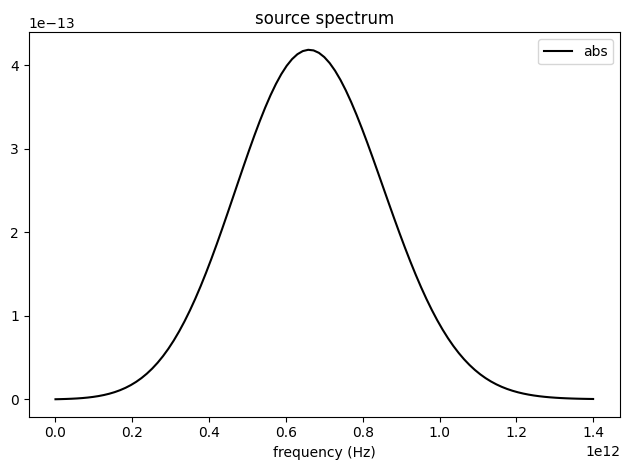

In [8]:
sim.sources[0].source_time.plot_spectrum(
    times=np.linspace(0, sim.run_time, 2000), val="abs"
)
plt.show()


Lastly, to ensure the geometry and mesh are set up appropriately, we visualize them before running the simulation.

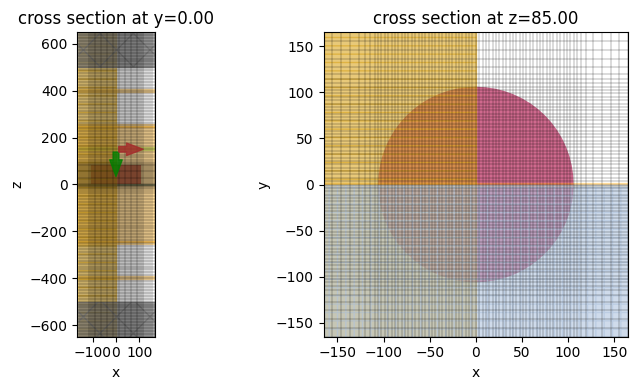

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
ax1 = sim.plot(y=0, ax=ax1)
ax1 = sim.plot_grid(y=0, ax=ax1)

ax2 = sim.plot(z=h, ax=ax2)
ax2 = sim.plot_grid(z=h, ax=ax2)


## Running Simulation

Submit the simulation to the server.

In [10]:
sim_data = web.run(
    sim, task_name="all_dielectric_metasurface_absorber", path="data/simulation.hdf5"
)


## Result Visualization 

After the simulation is complete, we visualize the reflectance, transmittance, and absorptance spectra. The absorption peak is observed around 0.6 THz as expected. The maximum absorption is around 95%.

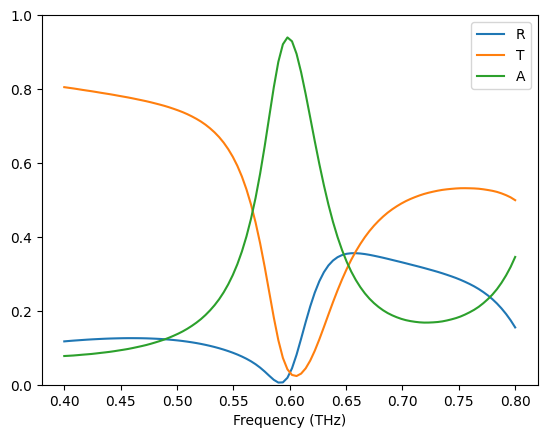

In [11]:
R = sim_data["R"].flux
T = -sim_data["T"].flux
A = 1 - R - T
freq_thz = np.linspace(0.4, 0.8, 100)
plt.plot(freq_thz, R, freq_thz, T, freq_thz, A)
plt.xlabel("Frequency (THz)")
plt.ylim(0, 1)
plt.legend(("R", "T", "A"))
plt.show()


Finally, we visualize the field intensity distribution at the resonance frequency. A strongly localized field within the silicon cylinder is observed, which indicates a high power dissipation due to the resonance mode of the cylinder.

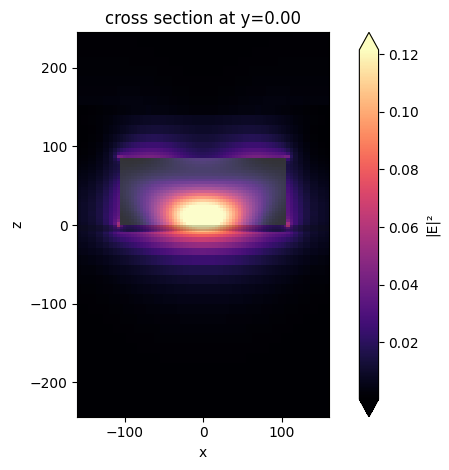

In [12]:
sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2")
plt.show()


## Finite Array of Unit Cells 

The periodic boundary condition indicates that the metasurface is infinitely large in the simulation. In practice, the fabricated metasurface is of course always made of only a finite number of unit cells. In addition, the spot size of the incident light is also finite. Therefore, only a certain number of unit cells are illuminated. 

Due to the above mentioned reasons, the transmission, reflection, or absorption spectrum might deviate from the perfectly periodic case. In this section, we model a finite array of unit cells illuminated by a focused Gaussian beam. Thanks to the highly optimized Tidy3D solver, such a large structure can be simulated with ease.

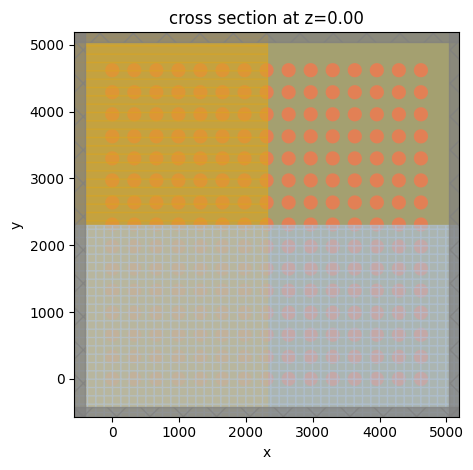

In [13]:
Nx = 15  # number of unit cells in the x direction
Ny = 15  # number of unit cells in the y direction
buffer = 0.5 * lda0  # buffer spacing in the x and y directions

# simulation domain size
Lx, Ly, Lz = Nx * p + 2 * buffer, Ny * p + 2 * buffer, 2 * lda0
sim_size = [Lx, Ly, Lz]

# systematicall construct the silicon resonators
metasurface = [substrate]
for i in range(Nx):
    for j in range(Ny):
        cylinder = td.Structure(
            geometry=td.Cylinder(
                center=[i * p, j * p, h / 2], radius=r, length=h, axis=2
            ),
            medium=Si,
        )
        metasurface.append(cylinder)

# define a gaussian beam with a waist radius of 3 wavelengths (focused beam)
gaussian = td.GaussianBeam(
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=0.5 * freqw),
    center=(p * (Nx // 2), p * (Ny // 2), 0.3 * lda0),
    direction="-",
    waist_radius=3 * lda0,
)

# define a field monitor to visualize the field distribution under gaussian beam excitation
monitor_field = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, td.inf, 0], freqs=[freq0], name="field"
)

sim = td.Simulation(
    size=sim_size,
    center=(p * (Nx // 2), p * (Ny // 2), 0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
    structures=metasurface,
    sources=[gaussian],
    monitors=[
        monitor_t,
        monitor_r,
        monitor_field,
    ],  # we will reuse the flux monitors defined earlier
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(
        boundary=td.PML()
    ),  # pml is applied in all boundaries
    symmetry=(-1, 1, 0),
)  # the same symmetry can be used

sim.plot(z=0)
plt.show()


In [14]:
sim_data = web.run(
    sim,
    task_name="all_dielectric_metasurface_absorber",
    path="data/simulation.hdf5",
    verbose=True,
)


[12:12:15] Created task 'all_dielectric_metasurface_absorber' with task_id                            ]8;id=349069;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=208669;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#139\139]8;;\
           'fdve-2f64d61b-5ddd-4765-b607-493a03286fefv1'.                                                          

Output()

[12:12:17] status = queued                                                                            ]8;id=84201;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=424342;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#269\269]8;;\

Output()

[12:12:19] status = preprocess                                                                        ]8;id=30177;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=63445;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#263\263]8;;\

[12:12:28] Maximum FlexCredit cost: 0.410. Use 'web.real_cost(task_id)' to get the billed FlexCredit cost ]8;id=680416;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=667592;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#286\286]8;;\
           after a simulation run.                                                                                 

           starting up solver                                                                         ]8;id=130669;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=52644;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#290\290]8;;\

           running solver                                                                             ]8;id=725382;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=191992;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#300\300]8;;\

Output()

[12:13:08] early shutoff detected, exiting.                                                           ]8;id=849245;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=452034;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#313\313]8;;\

           status = postprocess                                                                       ]8;id=56652;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=887592;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#330\330]8;;\

Output()

[12:13:15] status = success                                                                           ]8;id=543297;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=799237;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#337\337]8;;\

Output()

[12:13:17] loading SimulationData from data/simulation.hdf5                                           ]8;id=799457;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=689366;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#512\512]8;;\

After the simulation is complete, we visualize the reflectance, transmittance, and absorptance spectra in the same way. The spectra are similar to that obtained from the unit cell simulation with only minor differences. This result also verifies the validity of the unit cell simulation with the periodic condition.

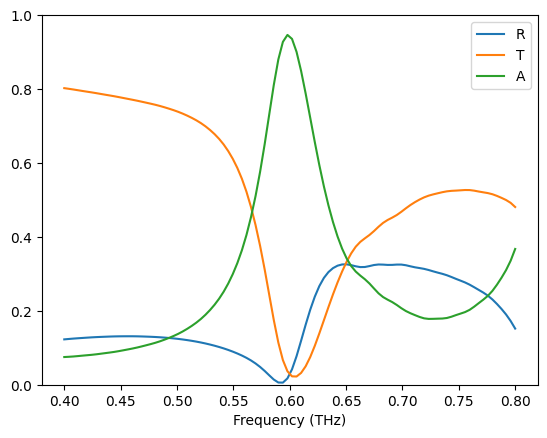

In [15]:
R = sim_data["R"].flux
T = -sim_data["T"].flux
A = 1 - R - T
freq_thz = np.linspace(0.4, 0.8, 100)
plt.plot(freq_thz, R, freq_thz, T, freq_thz, A)
plt.xlabel("Frequency (THz)")
plt.ylim(0, 1)
plt.legend(("R", "T", "A"))
plt.show()


The field intensity distribution reveals that only a small number of unit cells are excited by the gaussian beam.

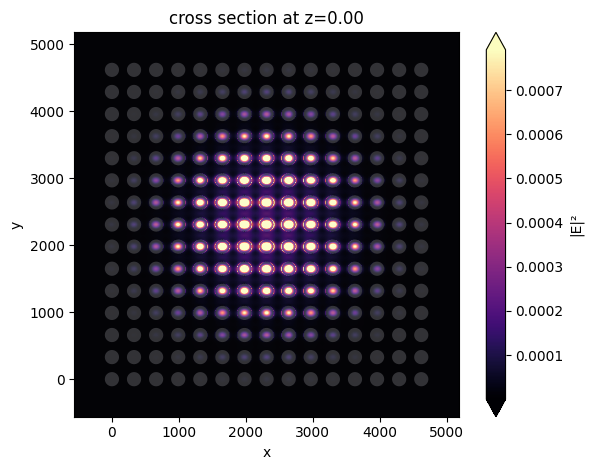

In [16]:
sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2")
plt.show()
